# Real Time Adjustment

In [2]:
import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gurobipy import GRB

%load_ext autoreload
%autoreload 2

from real_time_adj_original import *
from evaluation import *
from constants import *
from real_time_adjustment_utils import *
STARTING_TEST = HOURS_PER_MONTH
TEST_LENGTH = HOURS_PER_MONTH

## Load Data

In [3]:
def build_dataset(idx_start=0,idx_end=HOURS_PER_YEAR,start_date='01-01-2022', end_date='12-29-2022'):
    prices = pd.read_csv('./data/2020_data.csv', index_col=0)[HOURS_PER_MONTH:]
    prices.index = pd.date_range(start='01-31-2021', periods=len(prices), freq='h')
    prices = prices[idx_start:idx_end]
    prices = prices.drop(columns=['production_FC','Offshore DK1', 'Offshore DK2', 'Onshore DK1', 'Onshore DK2'])
    prices['production_RE'] *= NOMINAL_WIND
    
    forecasts = pd.read_csv('./forecasting/rolling_forecasts_2021_2022.csv', index_col=0)
    forecasts.index = pd.date_range(start='01-31-2021', periods=len(forecasts), freq='h')
    forecasts = forecasts[start_date:end_date][idx_start:idx_end]
    forecasts *= NOMINAL_WIND
    forecasts.clip(lower=0, upper=10,inplace=True)
    forecast_cols = [f'FC_{i}h' for i in range(1, 25)]
    forecasts['production_FC'] = forecasts[forecast_cols].values.tolist()
    forecasts.drop(columns=[f'FC_{i}h' for i in range(1, 25)],inplace=True)
    
    dataset = pd.concat([prices, forecasts], axis=1)
    
    return dataset

data = build_dataset()
display(data)

,forward_RE,forward_FC,UP,DW,production_RE,production_FC
2021-01-31 00:00:00,47.17,48.909440,47.17,47.17,9.460784,NaN
2021-01-31 01:00:00,45.47,48.758974,45.47,45.47,9.264706,NaN
2021-01-31 02:00:00,45.43,47.667859,45.43,45.43,8.970588,NaN
2021-01-31 03:00:00,46.82,45.207446,46.82,46.82,6.715686,NaN
2021-01-31 04:00:00,45.08,50.070133,45.08,45.08,5.931373,NaN
...,...,...,...,...,...,...
2022-12-29 19:00:00,NaN,NaN,NaN,NaN,NaN,"[1.969543673619796, 1.877005123028356, 1.56854..."
2022-12-29 20:00:00,NaN,NaN,NaN,NaN,NaN,"[1.763811478434287, 1.4651459235775899, 1.6344..."
2022-12-29 21:00:00,NaN,NaN,NaN,NaN,NaN,"[0.842635224166755, 1.06583083937895, 1.096143..."
2022-12-29 22:00:00,NaN,NaN,NaN,NaN,NaN,"[0.38055840558878296, 0.47017975356757, 0.9562..."


In [4]:
def import_data(idx_start=0, idx_end=HOURS_PER_YEAR):
    data = build_dataset(idx_start=idx_start, idx_end=idx_end)
    prices_B = np.maximum(data["UP"].to_numpy(), 0)
    prices_S = np.maximum(data["DW"].to_numpy(), 0)
    prices_F = np.maximum(data["forward_RE"].to_numpy(), 0)
    prices_forecast = np.maximum(data["forward_FC"].to_numpy(), 0)
    realized = data.loc[:, "production_RE"].to_numpy()
    # Make a column that is a list of the 24h forecasts
    power_forecasts = data.loc[:, "production_FC"].to_numpy()
    penalty = np.quantile(prices_B, 0.95)
    
    return prices_B, prices_S, prices_F, prices_forecast, realized, power_forecasts, penalty

## Hindsight 

In [5]:
def global_hindsight(idx_start, idx_end,h_min=H_MIN):
    prices_B, prices_S, prices_F, prices_forecast, realized, power_forecasts, penalty = import_data(idx_start, idx_end)
    
    ds,forward_bids, h_prods, ups, dws, objs, missing_productions = [], [], [], [], [], [], []
    
    for t in range(0, idx_end - idx_start, 24):

        # For each day, solve the optimization problem with full knowledge of the future
        model = gp.Model('Hindsight')
        
        # Variables
        p_adj = model.addMVar(shape=24, vtype=GRB.CONTINUOUS, name='p_adj', lb=0.0, ub=P_H_MAX)
        fw_bids = model.addMVar(shape=24, vtype=GRB.CONTINUOUS, name='forward_bids', lb=-P_H_MAX, ub=NOMINAL_WIND)
        up = model.addMVar(shape=24, vtype=GRB.CONTINUOUS, name='up', lb=0.0)
        dw = model.addMVar(shape=24, vtype=GRB.CONTINUOUS, name='dw', lb=0.0)
        up_aux = model.addMVar(shape=24, vtype=GRB.CONTINUOUS, name='up_aux', lb=-GRB.INFINITY)
        dw_aux = model.addMVar(shape=24, vtype=GRB.CONTINUOUS, name='dw_aux', lb=-GRB.INFINITY)
        
        # Objective
        model.setObjective(compute_objective_variable_bids(t, 24, p_adj, up, dw, fw_bids, prices_F, prices_S, prices_B), GRB.MAXIMIZE)
        
        # Constraints
        model.addConstr(h_min <= p_adj.sum(), 'Daily Production')
        
        for j in range(24):
            k = t + j
            settlement = realized[k] - fw_bids[j] - p_adj[j]
            model.addConstr(up_aux[j] == -settlement, f'up_aux_{j}')
            model.addConstr(dw_aux[j] == settlement, f'dw_aux_{j}')
            model.addGenConstrMax(up[j], [0, up_aux[j]], name=f'up_{j}')
            model.addGenConstrMax(dw[j], [0, dw_aux[j]], name=f'dw_{j}')
        
        model.setParam('OutputFlag', 0)
        model.setParam('DualReductions', 0)
        model.optimize()
        
        if model.status != GRB.OPTIMAL:
            print(f"Optimization failed at {t}")
            break
            
        for j in range(24):
            h_prods.append(p_adj[j].x)
            forward_bids.append(fw_bids[j].x)

    for t in range(idx_end - idx_start):
        h_adj = h_prods[t]
        forward_bid = forward_bids[t]
        if t % 24 == 0 and t != 0:
            missing_production = np.maximum(h_min - np.sum(h_prods[t-24:t]), 0)
        else:
            missing_production = 0
        settlement = realized[t] - forward_bid - h_adj
        
        up_val = np.maximum(-settlement, 0)
        dw_val = np.maximum(settlement, 0)
        obj_val = (
            forward_bid * prices_F[t]
            + PRICE_H * h_adj
            + dw_val * prices_S[t]
            - up_val * prices_B[t]
            - missing_production * penalty
        )
        
        ds.append(realized[t] - forward_bid)
        ups.append(up_val)
        dws.append(dw_val)
        missing_productions.append(missing_production)
        objs.append(obj_val)
    
    results = {}
    
    results['d'] = ds
    results['h_prod'] = h_prods
    results['forward_bid'] = forward_bids
    results['up'] = ups
    results['dw'] = dws
    results['missing_production'] = missing_productions
    results['obj'] = objs
    
    return results    

In [30]:
results_global_hindsight = global_hindsight(0, 12*HOURS_PER_MONTH)
print(f"Hindsight: {np.sum(results_global_hindsight['obj'])}")

IndexError: index 8112 is out of bounds for axis 0 with size 8112

In [20]:
hindsight_csv = pd.read_csv("./results/2020/hindsight.csv")
results_original = test_fixed(hindsight_csv['forward bid'], hindsight_csv['hydrogen production'], HOURS_PER_YEAR, HOURS_PER_YEAR + 12*HOURS_PER_MONTH, h_min=50)
print(f"Original: {np.sum(results_original['obj'])}")

Original: 1857385.4705882354


In [6]:
def best_adjustment(results_to_copy, idx_start, idx_end, h_min):
    prices_B, prices_S, prices_F, prices_forecast, realized, power_forecasts, penalty = import_data(idx_start, idx_end)
    print(f"Prices: {prices_B[0]}, {prices_S[0]}, {prices_F[0]}")
    print(f"Realized: {realized[0]}")
    
    results = copy.deepcopy(results_to_copy)
    
    ds, h_prods, ups, dws, objs, missing_productions = [], [], [], [], [], []
    
    forward_bids = results['forward_bid']
    
    h_prod = []
    
    for t in range(0, idx_end - idx_start, 24):
        # if (t//24)%10 == 0:
        #     print(f"Day {t // 24 + 1} of {idx_end // 24}")
        # For each day, solve the optimization problem with full knowledge of the future
        model = gp.Model('Hindsight')
        
        # Variables
        p_adj = model.addMVar(shape=24, vtype=GRB.CONTINUOUS, name='p_adj', lb=0.0, ub=P_H_MAX)
        up = model.addMVar(shape=24, vtype=GRB.CONTINUOUS, name='up', lb=0.0)
        dw = model.addMVar(shape=24, vtype=GRB.CONTINUOUS, name='dw', lb=0.0)
        up_aux = model.addMVar(shape=24, vtype=GRB.CONTINUOUS, name='up_aux', lb=-GRB.INFINITY)
        dw_aux = model.addMVar(shape=24, vtype=GRB.CONTINUOUS, name='dw_aux', lb=-GRB.INFINITY)
        
        # Objective
        model.setObjective(compute_objective_fixed_bids(t, 0, 24, p_adj, up, dw, forward_bids, prices_F, prices_S, prices_B), GRB.MAXIMIZE)
        
        # Constraints
        model.addConstr(h_min <= p_adj.sum(), 'Daily Production')
        
        for j in range(24):
            k = t + j
            settlement = realized[k] - forward_bids[k] - p_adj[j]
            model.addConstr(up_aux[j] == -settlement, f'up_aux_{j}')
            model.addConstr(dw_aux[j] == settlement, f'dw_aux_{j}')
            model.addGenConstrMax(up[j], [0, up_aux[j]], name=f'up_{j}')
            model.addGenConstrMax(dw[j], [0, dw_aux[j]], name=f'dw_{j}')
        
        model.setParam('OutputFlag', 0)
        model.setParam('DualReductions', 0)
        model.optimize()
        
        if model.status != GRB.OPTIMAL:
            print(f"Optimization failed at {t}")
            break
            
        for j in range(24):
            h_prod.append(p_adj[j].x)

    for t in range(idx_end - idx_start):
        h_adj = h_prod[t]
        if t % 24 == 0 and t != 0:
            missing_production = np.maximum(h_min - np.sum(h_prod[t-24:t]), 0)
        else:
            missing_production = 0
        settlement = realized[t] - forward_bids[t] - h_adj
        
        up_val = np.maximum(-settlement, 0)
        dw_val = np.maximum(settlement, 0)
        obj_val = (
            forward_bids[t] * prices_F[t]
            + PRICE_H * h_adj
            + dw_val * prices_S[t]
            - up_val * prices_B[t]
            - missing_production * penalty
        )
        
        ds.append(realized[t] - forward_bids[t])
        h_prods.append(h_adj)
        ups.append(up_val)
        dws.append(dw_val)
        missing_productions.append(missing_production)
        objs.append(obj_val)
    
    results['d'] = ds
    results['h_prod'] = h_prods
    results['up'] = ups
    results['dw'] = dws
    results['missing_production'] = missing_productions
    results['obj'] = objs
    
    return results    

## HAPD-AF-12

In [21]:
df_hapd_af_12 = pd.read_csv("results/2020/HAPD-AF-12-HMIN-PY.csv")

result_hapd_af_12 = test_price_domain(df_hapd_af_12, 12*HOURS_PER_MONTH, 12*HOURS_PER_MONTH + 12*HOURS_PER_MONTH,h_min=H_MIN)
print(f"HAPD-AF-12: {np.sum(result_hapd_af_12['obj'])}")

HAPD-AF-12: 1780971.9173018392


In [22]:
best_results = best_adjustment(result_hapd_af_12, 0, 12*HOURS_PER_MONTH, H_MIN)
print(f"Best Adjustment: {np.sum(best_results['obj'])}")

Prices: 34.0, 33.42, 33.42
Realized: 5.588235294117647
Best Adjustment: 1713441.2056144902


In [15]:
result_adj_hapd_af_12 = apply_up_and_dw_adj(result_hapd_af_12, 12*HOURS_PER_MONTH, 12*HOURS_PER_MONTH + 12*HOURS_PER_MONTH, h_min=H_MIN, printing=True)
print(np.sum(result_adj_hapd_af_12['obj']))

[33.11 32.93 32.   32.19 33.14 35.58 36.12 37.58 38.55 40.  ]
i=8, method 1: We changed from 0.0 to 1.839272519605749
i=9, method 1: We changed from 0.0 to 1.2603563951184347
i=10, method 1: We changed from 0.0 to 1.2709315266511731
i=11, method 1: We changed from 0.0 to 1.3994311229082617
i=12, method 1: We changed from 0.0 to 0.06614220904085344
i=13, method 1: We changed from 0.0 to 1.1325855228446242
i=153, method 1: We changed from 0.0 to 0.45677410521737416
i=154, method 1: We changed from 0.0 to 2.3319348297704874
i=155, method 1: We changed from 0.0 to 1.0999838050101673
i=157, method 1: We changed from 0.0 to 0.21624643964792556
i=158, method 1: We changed from 0.0 to 0.43716726340409284
i=160, method 1: We changed from 0.0 to 1.2630242485000696
i=162, method 1: We changed from 0.0 to 0.7279450548818902
i=164, method 1: We changed from 0.0 to 1.2252791644251104
i=227, method 1: We changed from 0.0 to 0.2644122091917729
i=228, method 1: We changed from 0.0 to 1.097460272449977


In [10]:
def MPC_adjustment(results_to_copy, idx_start, idx_end, h_min, verbose=False):
    results = copy.deepcopy(results_to_copy)
    prices_B, prices_S, prices_F, prices_forecast, realized, power_forecasts, penalty = import_data(idx_start, idx_end)

    forward_bids = results['forward_bid']

    ds, h_prods, ups, dws, objs, missing_productions = [], [], [], [], [], []
    missing_production = daily_count = 0
    
    for t in range(idx_end - idx_start):
        i = t % 24
        if i == 0 and t != 0:
            if verbose:
                print(f"Day {t // 24} of {(idx_end - idx_start) // 24} done")
            missing_production = max(h_min - daily_count, 0)
            daily_count = 0

        d = realized[t] - forward_bids[t]
        hours_left = 24 - i 
        
        if daily_count< h_min:    
            model = gp.Model('Real Time Adjustment')
    
            # Variables
            p_adj = model.addMVar(shape=hours_left, vtype=GRB.CONTINUOUS, name='p_adj', lb=0.0, ub=P_H_MAX)
            up = model.addMVar(shape=hours_left, vtype=GRB.CONTINUOUS, name='up', lb=0.0)
            dw = model.addMVar(shape=hours_left, vtype=GRB.CONTINUOUS, name='dw', lb=0.0)
            up_aux = model.addMVar(shape=hours_left, vtype=GRB.CONTINUOUS, name='up_aux', lb=-GRB.INFINITY)
            dw_aux = model.addMVar(shape=hours_left, vtype=GRB.CONTINUOUS, name='dw_aux', lb=-GRB.INFINITY)
    
            # Objective
            model.setObjective(compute_objective_fixed_bids(t, hours_left, p_adj, up, dw, forward_bids, prices_F, prices_S, prices_B), GRB.MAXIMIZE)
    
            # Constraints
            model.addConstr(h_min <= p_adj.sum() + daily_count, 'Daily Production')
    
            for j in range(hours_left):
                k = t + j
                settlement = realized[k] - forward_bids[k] - p_adj[j] if j == 0 else power_forecasts[t][j] - forward_bids[k] - p_adj[j]
                model.addConstr(up_aux[j] == -settlement, f'up_aux_{j}')
                model.addConstr(dw_aux[j] == settlement, f'dw_aux_{j}')
                model.addGenConstrMax(up[j], [0, up_aux[j]], name=f'up_{j}')
                model.addGenConstrMax(dw[j], [0, dw_aux[j]], name=f'dw_{j}')
    
            model.setParam('OutputFlag', 0)
            model.setParam('DualReductions', 0)
            model.optimize()
    
            if model.status != GRB.OPTIMAL:
                if verbose:
                    print(f"Optimization failed at {t}")
                break
            
            h_adj = np.maximum(0, np.minimum(P_H_MAX, p_adj[0].x))
            
        else:
            h_adj = get_hydro_opt(realized[t] - forward_bids[t], prices_S[t], prices_B[t])
        
        daily_count += h_adj
        settlement = realized[t] - forward_bids[t] - h_adj

        up_val = np.maximum(-settlement, 0)
        dw_val = np.maximum(settlement, 0)
        obj_val = (
            forward_bids[t] * prices_F[t]
            + PRICE_H * h_adj
            + dw_val * prices_S[t]
            - up_val * prices_B[t]
            - missing_production * penalty
        )

        ds.append(d)
        h_prods.append(h_adj)
        ups.append(up_val)
        dws.append(dw_val)
        missing_productions.append(missing_production)
        objs.append(obj_val)
        missing_production = 0

        if verbose:
            print(f"Time {t}:")
            print(f"  Prices: {prices_B[t]}, {prices_S[t]}, {prices_F[t]}")
            print(f"  Forward Bid: {forward_bids[t]}")
            print(f"  Realized: {realized[t]}")
            print(f"  Adjustment: {h_adj}")
            print(f"Whole trajectory: {p_adj.x}")
            print(f" up: {up.x}")
            print(f" dw: {dw.x}")
            print(f"  Settlement: {settlement}")
            print(f"  Objective Value: {obj_val}")

    results['d'] = ds
    results['h_prod'] = h_prods
    results['up'] = ups
    results['dw'] = dws
    results['missing_production'] = missing_productions
    results['obj'] = objs

    return results

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_objectives(original_obj, original_adj_obj, mpc_adj_obj, local_hindsight_obj, model_names, h_min, save_fig=False, fig_name=None):
    bar_width = 0.4
    adjust_width = bar_width / 2
    r1 = np.arange(len(original_obj))
    colors = sns.color_palette("deep", 4)

    plt.bar(r1, original_obj, color=colors[0], width=bar_width, label='Day-ahead')
    plt.bar(r1 - adjust_width/2, original_adj_obj, bottom=original_obj, color=colors[2], width=adjust_width, label='Adjustment rule')
    plt.bar(r1 + adjust_width/2, mpc_adj_obj, bottom=original_obj, color=colors[1], width=adjust_width, label='MPC adjustment')
    plt.axhline(y=original_obj[0], color='black', linestyle='--', label='Global hindsight')

    if local_hindsight_obj is not None:
        local_hindsight_label_added = False
        # Add a line that is the size of the bar to represent the local hindsight for each model
        for i, obj in enumerate(local_hindsight_obj):
            xval = r1[i] - bar_width / 2  # Start of the bar
            width = bar_width  # Width of the bar
            yval = obj  # Top of the bar including local hindsight value
            if not local_hindsight_label_added:
                plt.plot([xval, xval + width], [yval, yval], color=colors[3], linestyle=':', linewidth=2, label='Local hindsight')
                local_hindsight_label_added = True
            else:
                plt.plot([xval, xval + width], [yval, yval], color=colors[3], linestyle=':', linewidth=2)


    plt.xlabel('Model', fontweight='bold')
    plt.ylabel('Objective Value', fontweight='bold')
    plt.xticks(r1, model_names)
    plt.legend()
    plt.title(f'Objective Values for Models with H_MIN={h_min}')
    plt.ylim(min(original_obj) * 0.95, np.max([np.array(original_obj) + np.array(original_adj_obj), np.array(original_obj) + np.array(mpc_adj_obj)]) * 1.05)
    plt.show()

    if save_fig:
        plt.savefig(fig_name)

In [22]:
def compute_metrics(results, model_name, h_min, filename):
    day_ahead_obj = np.sum(results[0]['obj'])
    adj_rule_obj = np.sum(results[1]['obj']) - day_ahead_obj
    mpc_adj_obj = np.sum(results[2]['obj']) - day_ahead_obj
    local_hindsight_obj = np.sum(results[3]['obj']) - day_ahead_obj
    
    missed_adj_opp_original = local_hindsight_obj - adj_rule_obj
    missed_adj_opp_mpc = local_hindsight_obj - mpc_adj_obj
    
    if adj_rule_obj == 0:
        relative_missed_adj_opp_original = 0
        relative_missed_adj_opp_mpc = 0
    else:
        relative_missed_adj_opp_original = missed_adj_opp_original / adj_rule_obj
        relative_missed_adj_opp_mpc = missed_adj_opp_mpc / mpc_adj_obj

    # Create a DataFrame with the specified columns
    metrics = [
        {
            'H_MIN': h_min,
            'Model': model_name,
            'Day-ahead Objective': day_ahead_obj,
            'Local Hindsight': local_hindsight_obj,
            'Adjustment Type': 'Rule-based',
            'Adjustment Value': adj_rule_obj,
            'MAO': missed_adj_opp_original,
            'RMAO': relative_missed_adj_opp_original
        },
        {
            'H_MIN': h_min,
            'Model': model_name,
            'Day-ahead Objective': day_ahead_obj,
            'Local Hindsight': local_hindsight_obj,
            'Adjustment Type': 'MPC',
            'Adjustment Value': mpc_adj_obj,
            'MAO': missed_adj_opp_mpc,
            'RMAO': relative_missed_adj_opp_mpc
        }
    ]
    
    df = pd.DataFrame(metrics)
    
    # Print the DataFrame
    print("-" * 50)
    display(df)
    
    return df

def build_metrics(results,model_names, filenames, h_min):
    metrics = [compute_metrics(results[model_name], model_name, h_min, f"./results/2020/{model_name}-{filename}.csv") for model_name, filename in zip(model_names[1:], filenames[1:])]
    metrics = pd.concat(metrics, ignore_index=True)
    metrics['Global Hindsight'] = np.sum(results['Global hindsight'][0]['obj'])
    # Put the column in the second position
    metrics = metrics[['H_MIN', 'Model', 'Global Hindsight', 'Day-ahead Objective', 'Local Hindsight', 'Adjustment Type', 'Adjustment Value', 'MAO', 'RMAO']]
    metrics.to_csv(f"./results/2020/real_time_adjustment/metrics-HMIN{h_min}.csv")

In [11]:
def test_adjustment_rules(model_name, filename, idx_start, idx_end, h_min, compute_local_hindsight=True):
    df = pd.read_csv(f"./results/2020/{filename}.csv")
    if model_name in ['Deterministic']:
        df = df[idx_start:idx_end]
        df.index = range(len(df))
        results = test_fixed(df['forward bid'], df['hydrogen production'], HOURS_PER_YEAR + idx_start, HOURS_PER_YEAR + idx_end, h_min)
    else:
        results = test_price_domain(df, HOURS_PER_YEAR + idx_start, HOURS_PER_YEAR + idx_end, h_min)
    results_adj = apply_up_and_dw_adj(results, HOURS_PER_YEAR + idx_start, HOURS_PER_YEAR + idx_end, h_min)
    results_mpc = MPC_adjustment(results, idx_start, idx_end, h_min, verbose=False)
    if compute_local_hindsight:
        results_local_hindsight = best_adjustment(results, idx_start, idx_end, h_min)
    else:
        results_local_hindsight = None
    print(f"Model: {model_name} done")
    return results, results_adj, results_mpc, results_local_hindsight

In [12]:
def test_models(model_names, filenames, idx_start, idx_end, compute_local_hindsight=True,h_min=H_MIN, plot=True):
    
    # Test the models
    results = {model_name: test_adjustment_rules(model_name,filename, idx_start, idx_end,h_min) for model_name, filename in zip(model_names, filenames)}
    
    # Compute the global hindsight
    global_hindsight_results = global_hindsight(idx_start, idx_end,h_min)
    results['Global hindsight'] = (global_hindsight_results, global_hindsight_results, global_hindsight_results, global_hindsight_results if compute_local_hindsight else None)
    model_names.insert(0, 'Global hindsight')
    filenames.insert(0, 'global_hindsight')
    print(f"Global hindsight done")

    if plot:
        original_obj = [np.sum(results[model_name][0]['obj']) for model_name in model_names]
        original_adj_obj = [np.sum(results[model_name][1]['obj']) - original_obj[i] for i, model_name in enumerate(model_names)]
        mpc_adj_obj = [np.sum(results[model_name][2]['obj']) - original_obj[i] for i, model_name in enumerate(model_names)]
        local_hindsight_obj = [np.sum(results[model_name][3]['obj']) for model_name in model_names] if compute_local_hindsight else None
        print(local_hindsight_obj)
        plot_objectives(original_obj, original_adj_obj, mpc_adj_obj, local_hindsight_obj, model_names,h_min)
    
    # Compute and save the metrics
    build_metrics(results,model_names, filenames, h_min)
                  
    return results

In [13]:
model_names = ['Deterministic', 'HAPD-AF-12']
filenames = ['deterministic-12-HMIN50', 'HAPD-AF-12-HMIN50']
results = test_models(model_names, filenames, 0, 12*HOURS_PER_MONTH,h_min=50)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-27


KeyboardInterrupt: 

Model: Deterministic done
Model: HAPD-AF-12 done
Global hindsight done
[1857385.4705882354, 1810759.9021540335, 1817469.0622786295]


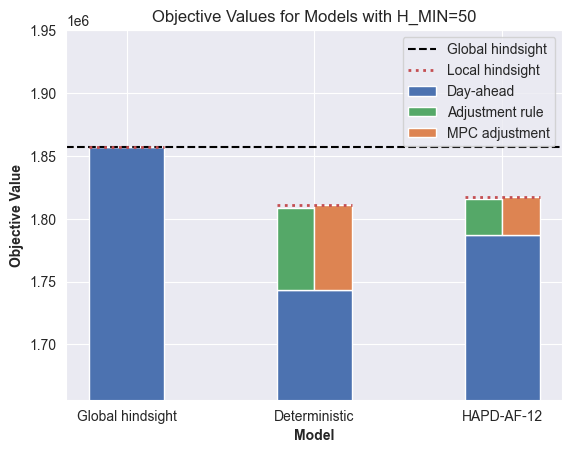

--------------------------------------------------
   H_MIN          Model  Day-ahead Objective  Local Hindsight Adjustment Type  \
0     50  Deterministic         1.742988e+06     67772.396301      Rule-based   
1     50  Deterministic         1.742988e+06     67772.396301             MPC   

   Adjustment Value          MAO      RMAO  
0      65362.328923  2410.067379  0.036872  
1      67626.378348   146.017954  0.002159  
--------------------------------------------------
   H_MIN       Model  Day-ahead Objective  Local Hindsight Adjustment Type  \
0     50  HAPD-AF-12         1.787233e+06     30235.933528      Rule-based   
1     50  HAPD-AF-12         1.787233e+06     30235.933528             MPC   

   Adjustment Value          MAO      RMAO  
0      28585.342467  1650.591060  0.057743  
1      30167.366963    68.566565  0.002273  
Model: Deterministic done
Model: HAPD-AF-12 done


KeyboardInterrupt: 

In [14]:
h_mins = [50,75,100,125,150]
total_results = {}
for h_min in h_mins:
    model_names = ['Deterministic', 'HAPD-AF-12']
    filenames = [f'deterministic-12-HMIN{h_min}', f'HAPD-AF-12-HMIN{h_min}']
    results = test_models(model_names, filenames, 0, 12*HOURS_PER_MONTH,h_min=h_min)
    total_results[h_min] = results

Model: Deterministic done
Model: HAPD-AF-12 done
Global hindsight done
[1851652.7705882352, 1805905.8324428345, 1811466.8825805988]


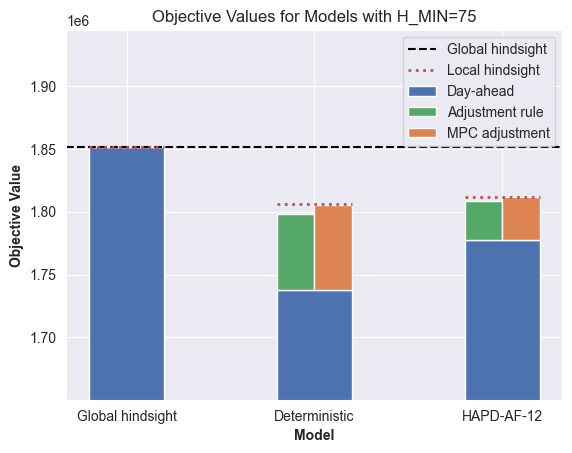

--------------------------------------------------
   H_MIN          Model  Day-ahead Objective  Local Hindsight Adjustment Type  \
0     75  Deterministic         1.737412e+06      68493.82659      Rule-based   
1     75  Deterministic         1.737412e+06      68493.82659             MPC   

   Adjustment Value          MAO      RMAO  
0      60886.034757  7607.791834  0.124951  
1      68122.426728   371.399863  0.005452  
--------------------------------------------------
   H_MIN       Model  Day-ahead Objective  Local Hindsight Adjustment Type  \
0     75  HAPD-AF-12         1.777682e+06     33785.074167      Rule-based   
1     75  HAPD-AF-12         1.777682e+06     33785.074167             MPC   

   Adjustment Value          MAO      RMAO  
0      30507.325837  3277.748330  0.107441  
1      33565.978071   219.096096  0.006527  


In [18]:
model_names = ['Deterministic', 'HAPD-AF-12']
filenames = ['deterministic-12-HMIN75', 'HAPD-AF-12-HMIN75']
results = test_models(model_names, filenames, 0, 12*HOURS_PER_MONTH,h_min=75)
total_results[75] = results

Model: Deterministic done
Model: HAPD-AF-12 done
Global hindsight done
[1836495.7705882352, 1790477.9080967812, 1792924.5293640075]


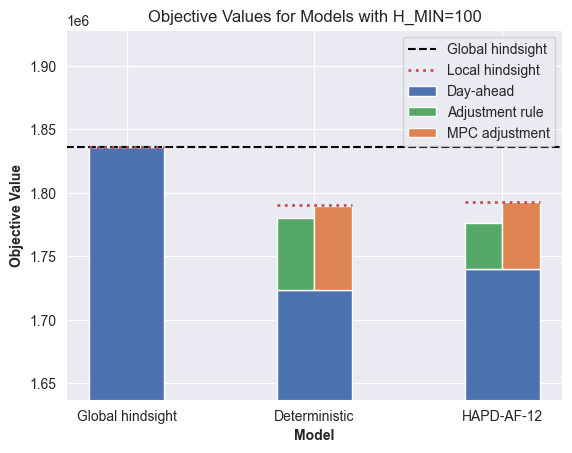

--------------------------------------------------
   H_MIN          Model  Day-ahead Objective  Local Hindsight Adjustment Type  \
0    100  Deterministic         1.723099e+06     67379.202244      Rule-based   
1    100  Deterministic         1.723099e+06     67379.202244             MPC   

   Adjustment Value           MAO      RMAO  
0      57312.475303  10066.726941  0.175646  
1      66728.122588    651.079657  0.009757  
--------------------------------------------------
   H_MIN       Model  Day-ahead Objective  Local Hindsight Adjustment Type  \
0    100  HAPD-AF-12         1.739692e+06     53232.761232      Rule-based   
1    100  HAPD-AF-12         1.739692e+06     53232.761232             MPC   

   Adjustment Value           MAO      RMAO  
0      36701.902986  16530.858246  0.450409  
1      52786.785813    445.975419  0.008449  


In [19]:
model_names = ['Deterministic', 'HAPD-AF-12']
filenames = ['deterministic-12-HMIN100', 'HAPD-AF-12-HMIN100']
results = test_models(model_names, filenames, 0, 12*HOURS_PER_MONTH,h_min=100)
total_results[100] = results

Model: Deterministic done
Model: HAPD-AF-12 done
Global hindsight done
[1807830.0705882353, 1762105.2124146628, 1763097.512091066]


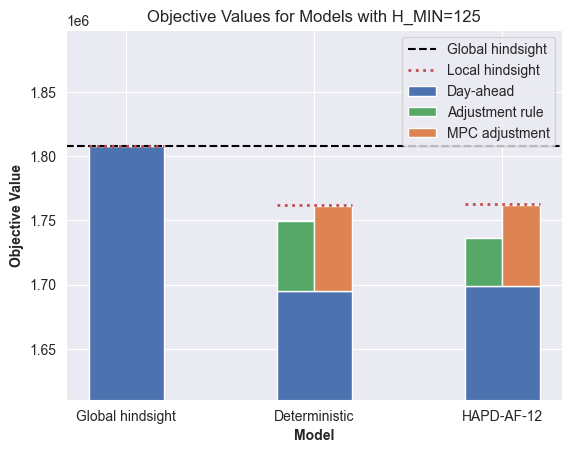

--------------------------------------------------
   H_MIN          Model  Day-ahead Objective  Local Hindsight Adjustment Type  \
0    125  Deterministic         1.695088e+06     67017.106562      Rule-based   
1    125  Deterministic         1.695088e+06     67017.106562             MPC   

   Adjustment Value           MAO      RMAO  
0      54410.177972  12606.928591  0.231702  
1      66149.949082    867.157480  0.013109  
--------------------------------------------------
   H_MIN       Model  Day-ahead Objective  Local Hindsight Adjustment Type  \
0    125  HAPD-AF-12         1.699053e+06     64044.112749      Rule-based   
1    125  HAPD-AF-12         1.699053e+06     64044.112749             MPC   

   Adjustment Value           MAO      RMAO  
0      36920.089357  27124.023393  0.734668  
1      63248.212912    795.899837  0.012584  


In [20]:
model_names = ['Deterministic', 'HAPD-AF-12']
filenames = ['deterministic-12-HMIN125', 'HAPD-AF-12-HMIN125']
xresults = test_models(model_names, filenames, 0, 12*HOURS_PER_MONTH,h_min=125)
total_results[125] = results

Model: Deterministic done
Model: HAPD-AF-12 done
Global hindsight done
[1765968.1705882354, 1720380.4449313327, 1717505.664312895]


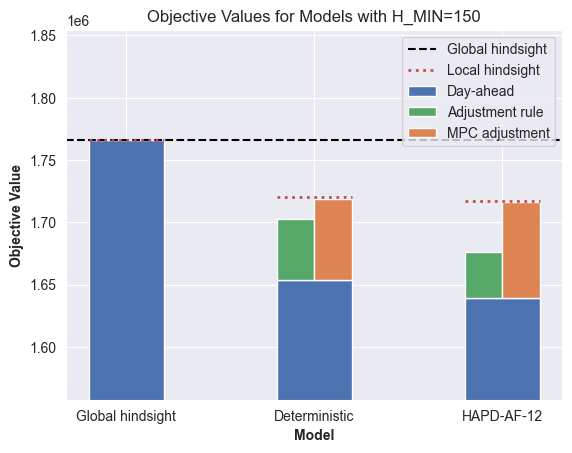

--------------------------------------------------
   H_MIN          Model  Day-ahead Objective  Local Hindsight Adjustment Type  \
0    150  Deterministic         1.653777e+06     66603.239079      Rule-based   
1    150  Deterministic         1.653777e+06     66603.239079             MPC   

   Adjustment Value           MAO      RMAO  
0      49265.287478  17337.951601  0.351930  
1      65259.066198   1344.172881  0.020597  
--------------------------------------------------
   H_MIN       Model  Day-ahead Objective  Local Hindsight Adjustment Type  \
0    150  HAPD-AF-12         1.639701e+06     77804.455433      Rule-based   
1    150  HAPD-AF-12         1.639701e+06     77804.455433             MPC   

   Adjustment Value           MAO      RMAO  
0      36829.367137  40975.088297  1.112566  
1      76918.385311    886.070123  0.011520  


In [21]:
model_names = ['Deterministic', 'HAPD-AF-12']
filenames = ['deterministic-12-HMIN150', 'HAPD-AF-12-HMIN150']
results = test_models(model_names, filenames, 0, 12*HOURS_PER_MONTH,h_min=150)
total_results[150] = results

In [23]:
# Save the results
import pickle
with open("./results/2020/real_time_adjustment/total_results.pkl", "wb") as f:
    pickle.dump(total_results, f)